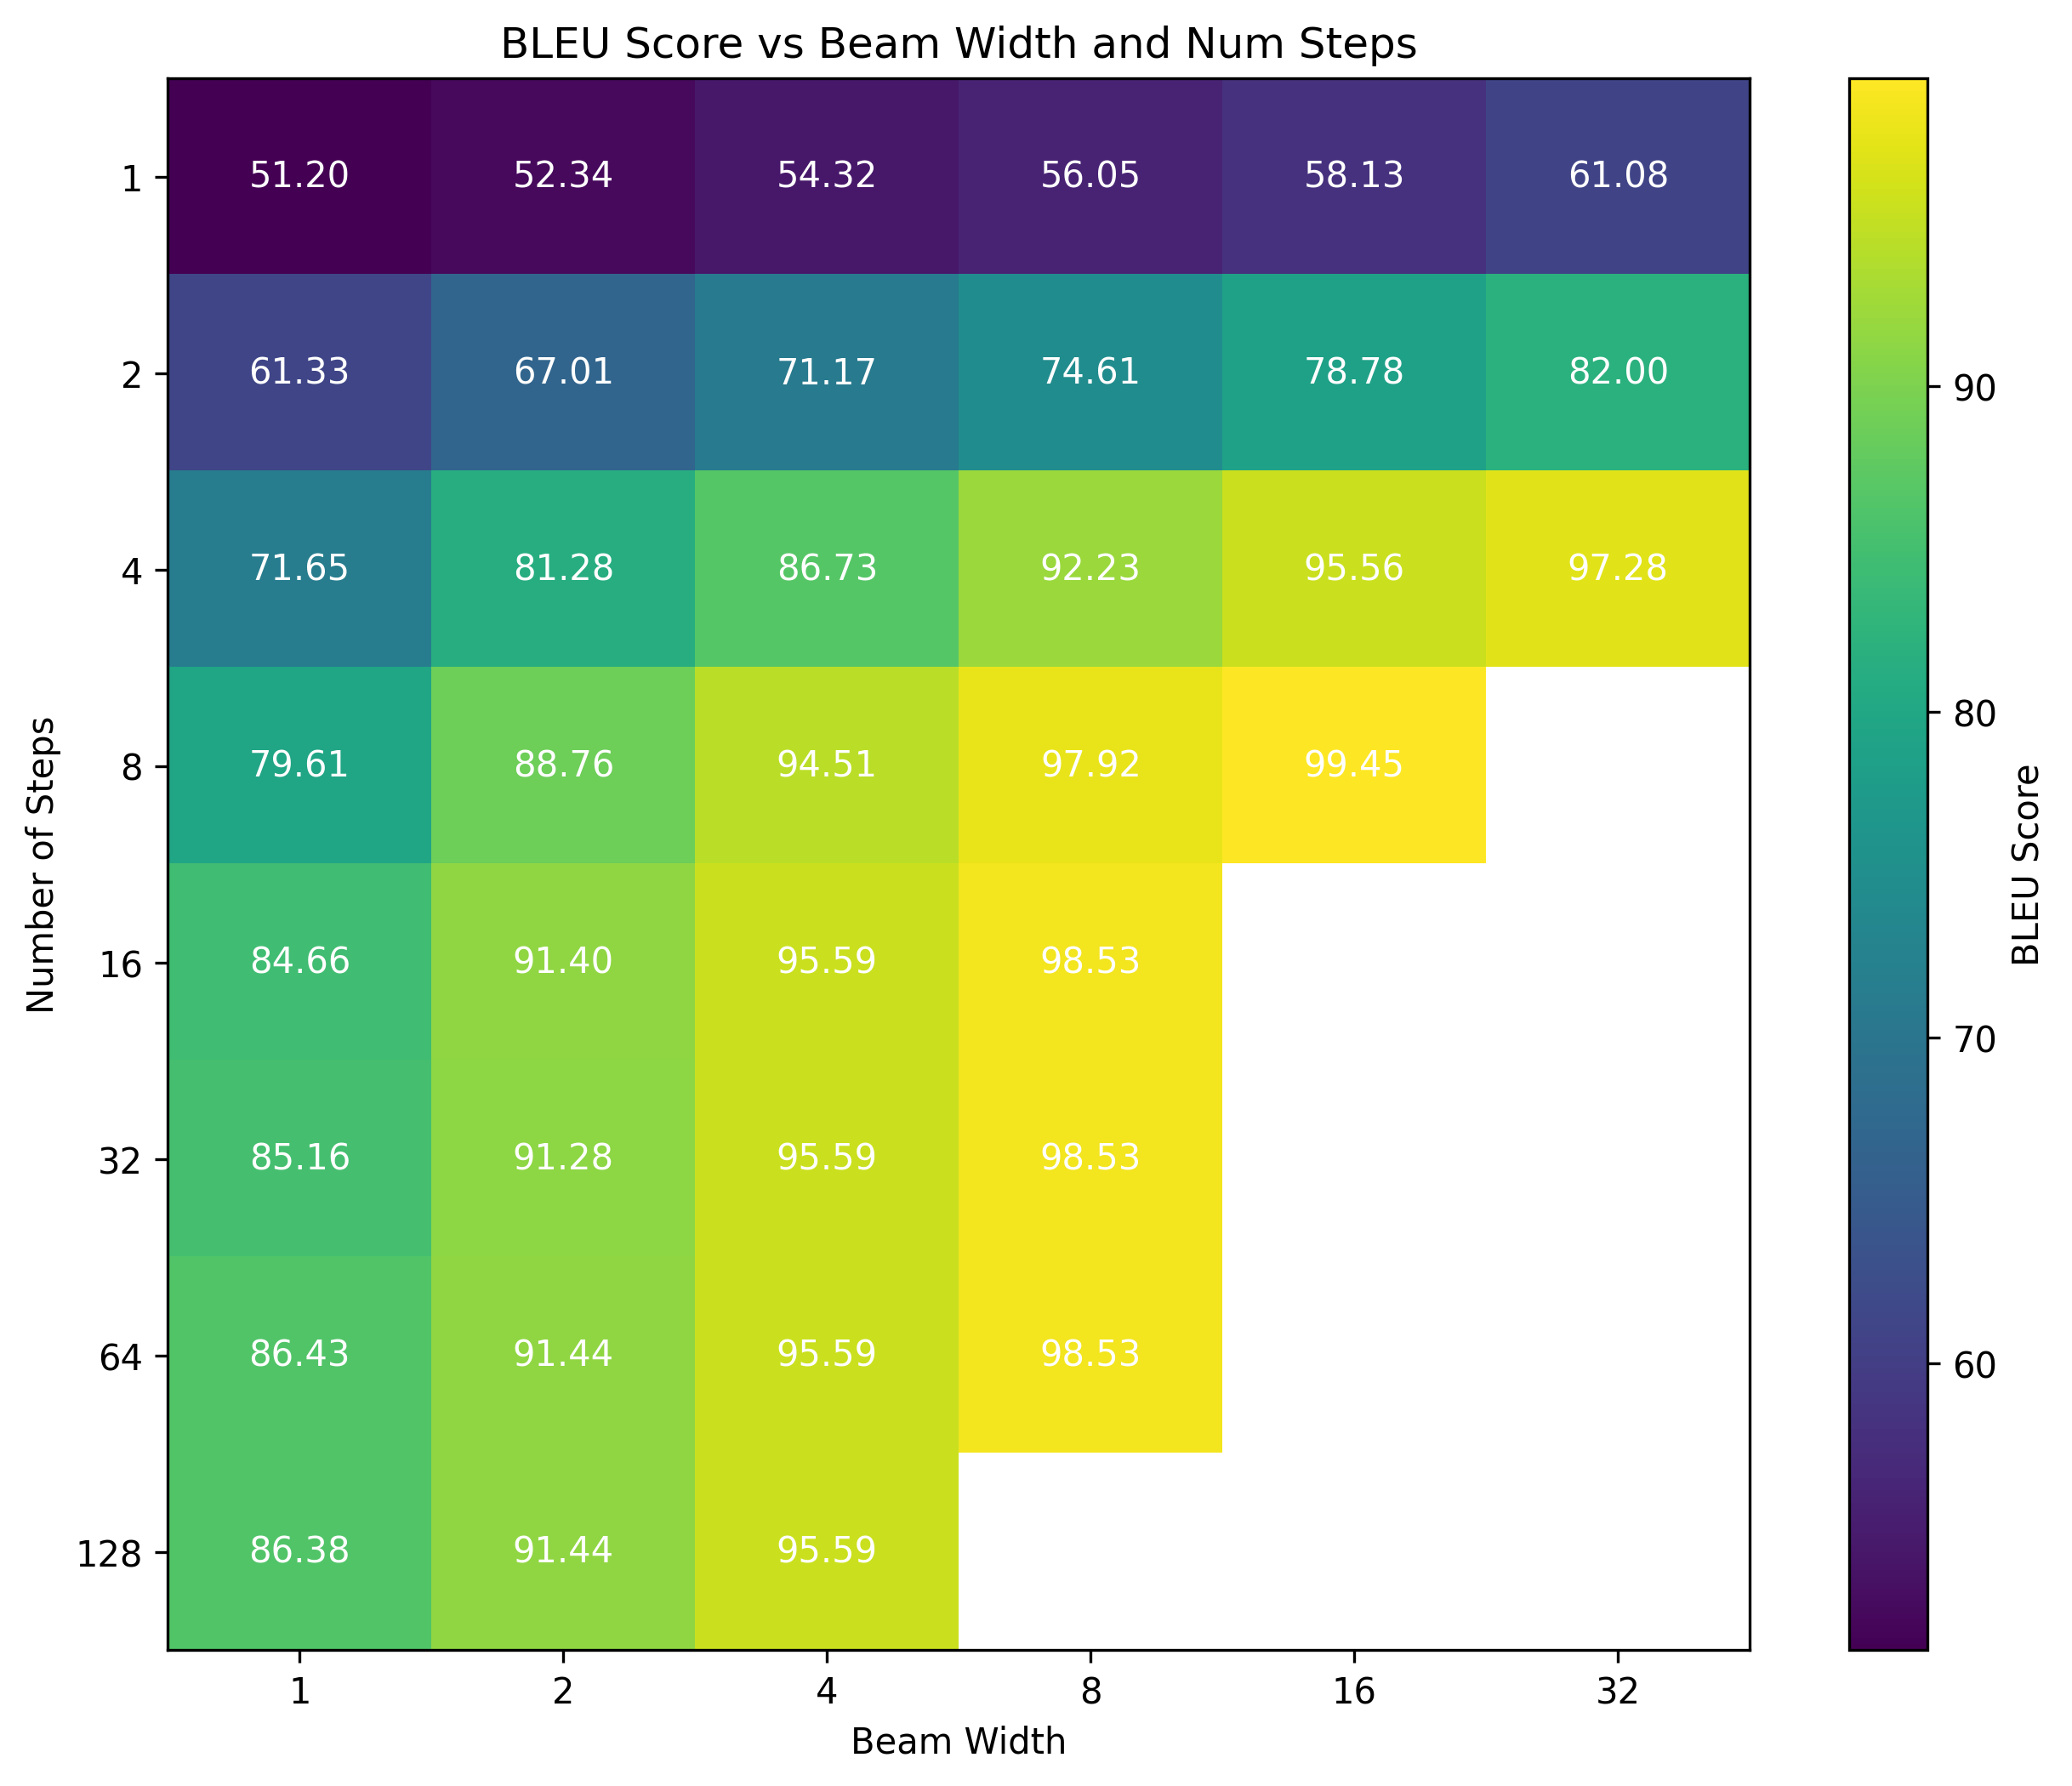

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("./data/num_steps_vs_beam_width.csv")
data = data[["num_steps", "sequence_beam_width", "bleu_score"]]

data.dropna(inplace=True)

data["num_steps"] = data["num_steps"].astype(int)
data["sequence_beam_width"] = data["sequence_beam_width"].astype(int)

pivot_table = data.pivot_table(
    index="num_steps", columns="sequence_beam_width", values="bleu_score", aggfunc="mean"
)

pivot_table = pivot_table.sort_index()
pivot_table = pivot_table.sort_index(axis=1)

plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(pivot_table, cmap="viridis", aspect="auto")

cbar = plt.colorbar()
cbar.set_label("BLEU Score")

plt.xticks(np.arange(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(np.arange(len(pivot_table.index)), pivot_table.index)
plt.xlabel("Beam Width")
plt.ylabel("Number of Steps")
plt.title("BLEU Score vs Beam Width and Num Steps")

for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        score = pivot_table.iloc[i, j]
        plt.text(j, i, f"{score:.2f}", ha="center", va="center", color="white")

plt.savefig("num_steps_vs_beam_width.pdf")

plt.show()

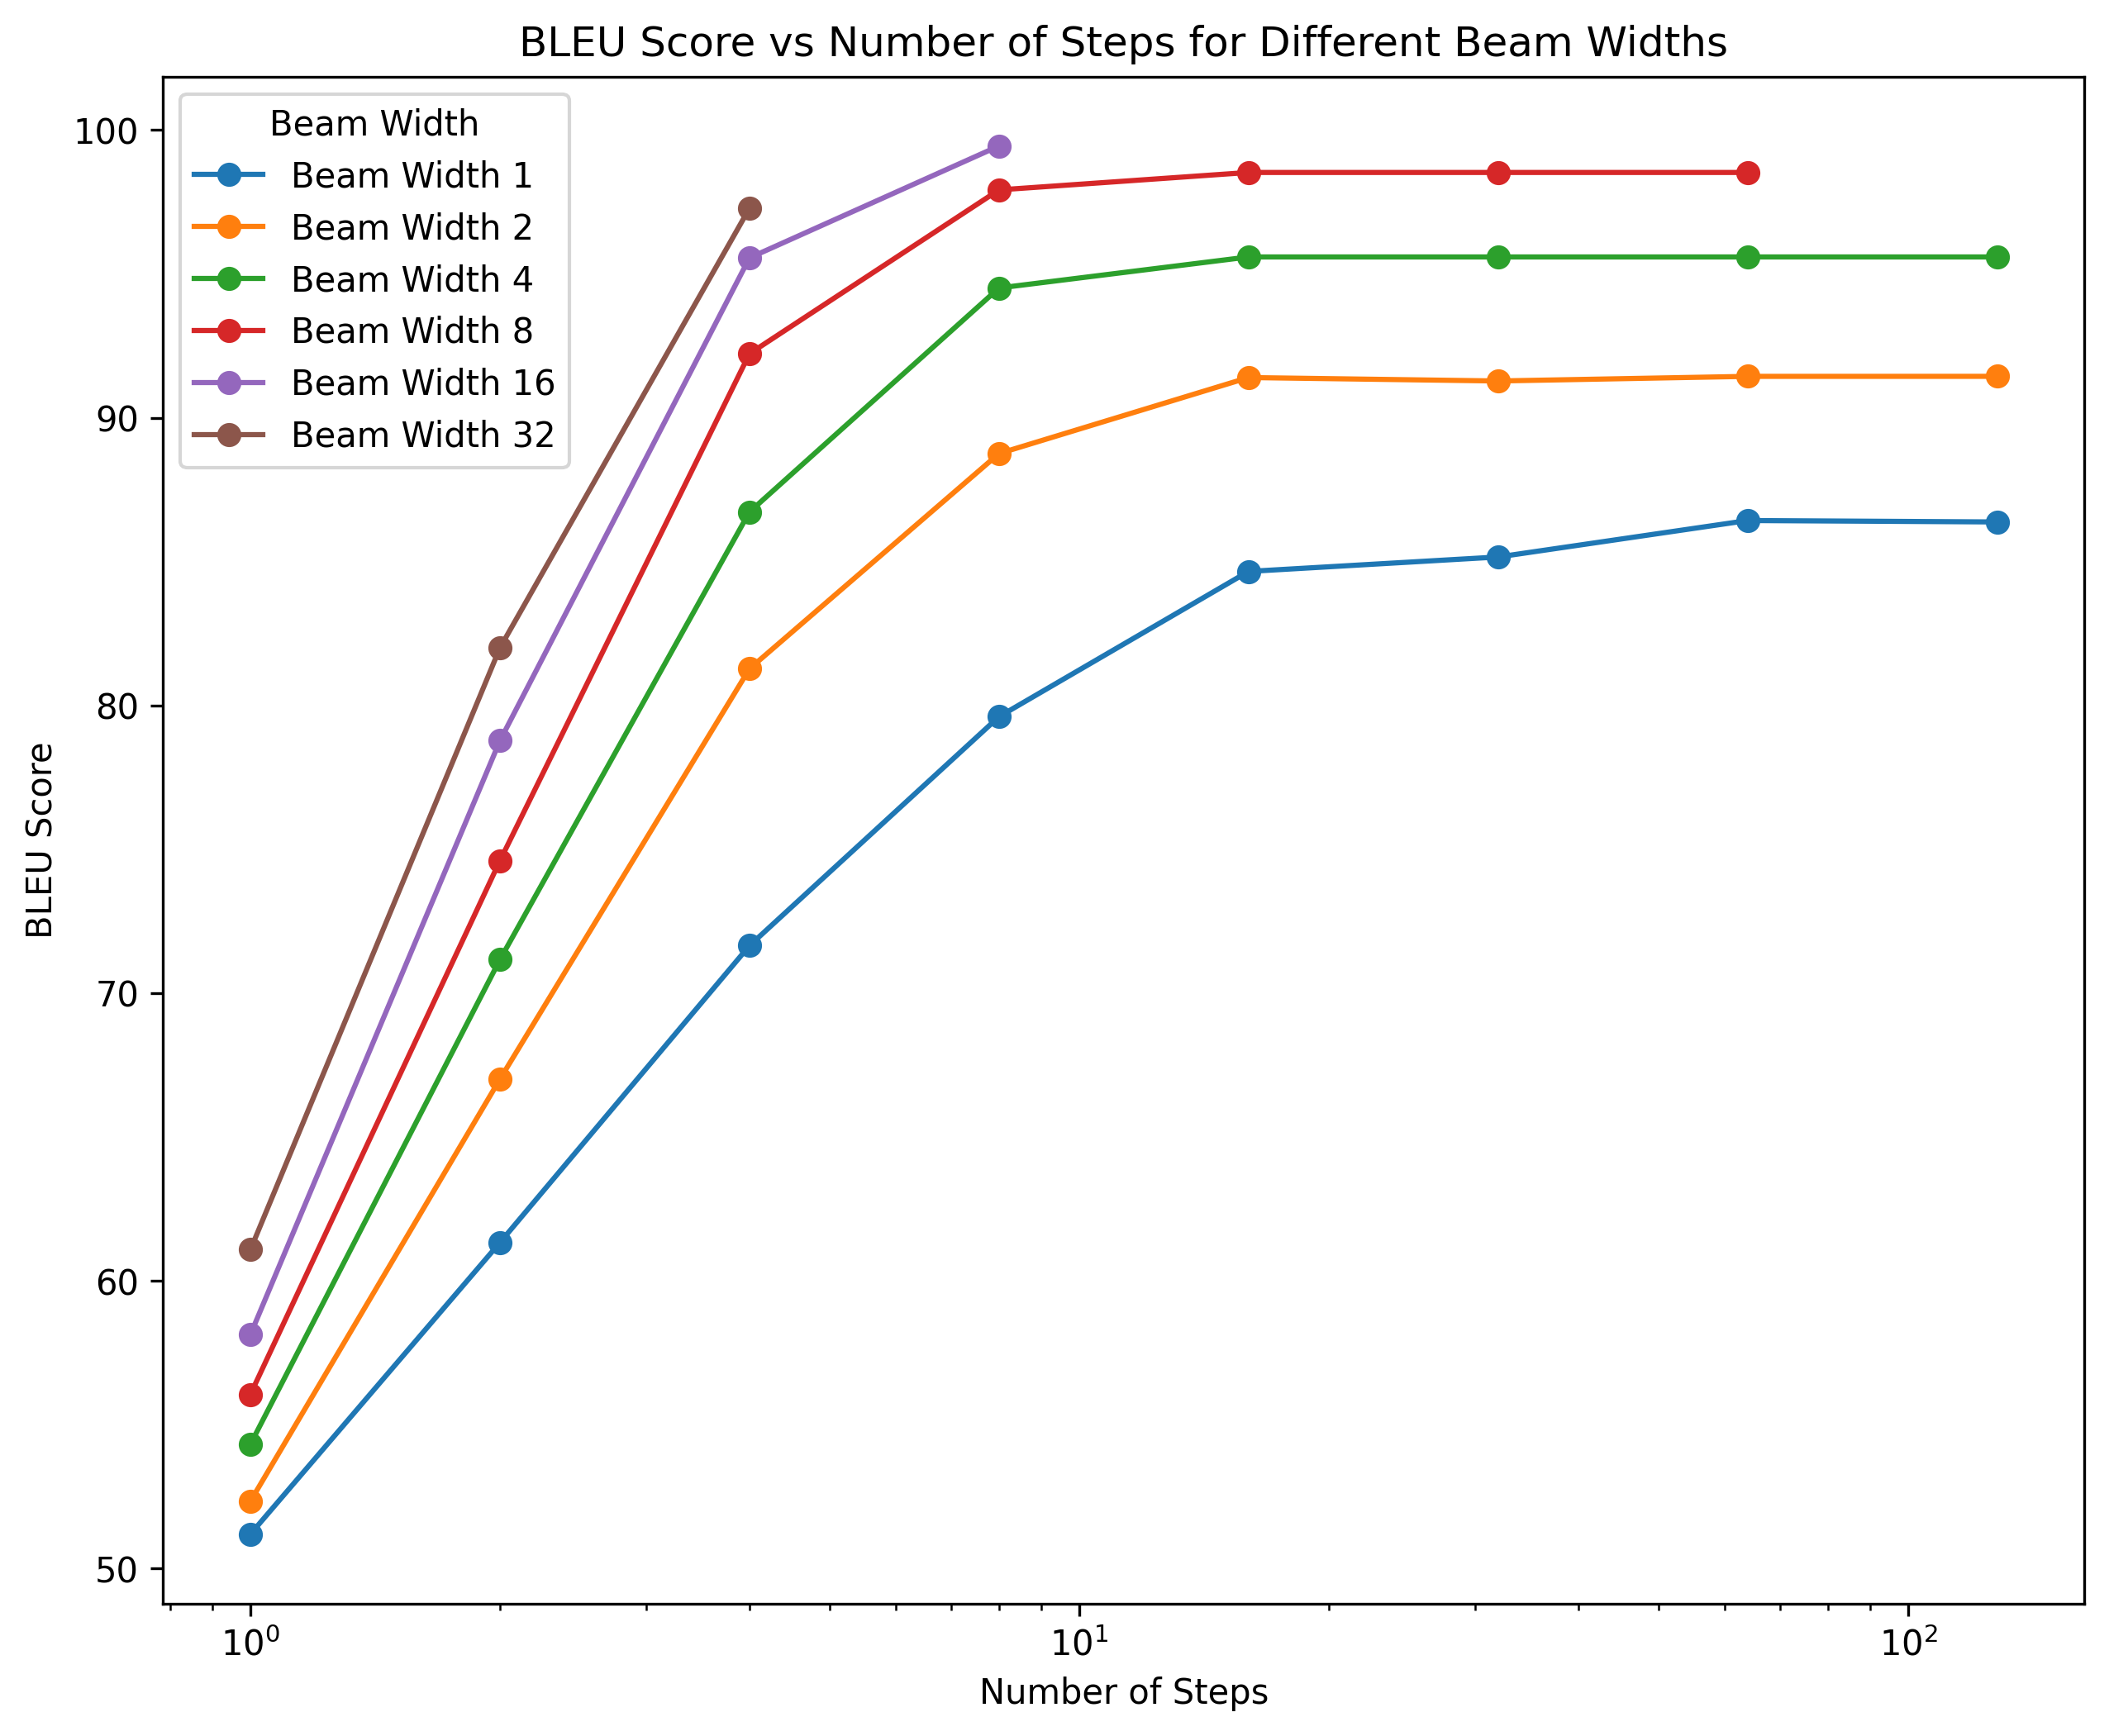

In [2]:

plt.figure(figsize=(10, 8), dpi=300)

for beam_width in pivot_table.columns:
    plt.plot(
        pivot_table.index, pivot_table[beam_width], marker="o", label=f"Beam Width {beam_width}"
    )

plt.xscale("log")

plt.xlabel("Number of Steps")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs Number of Steps for Different Beam Widths")

plt.legend(title="Beam Width")

plt.savefig("num_steps_vs_beam_width_line_chart.pdf")

plt.show()

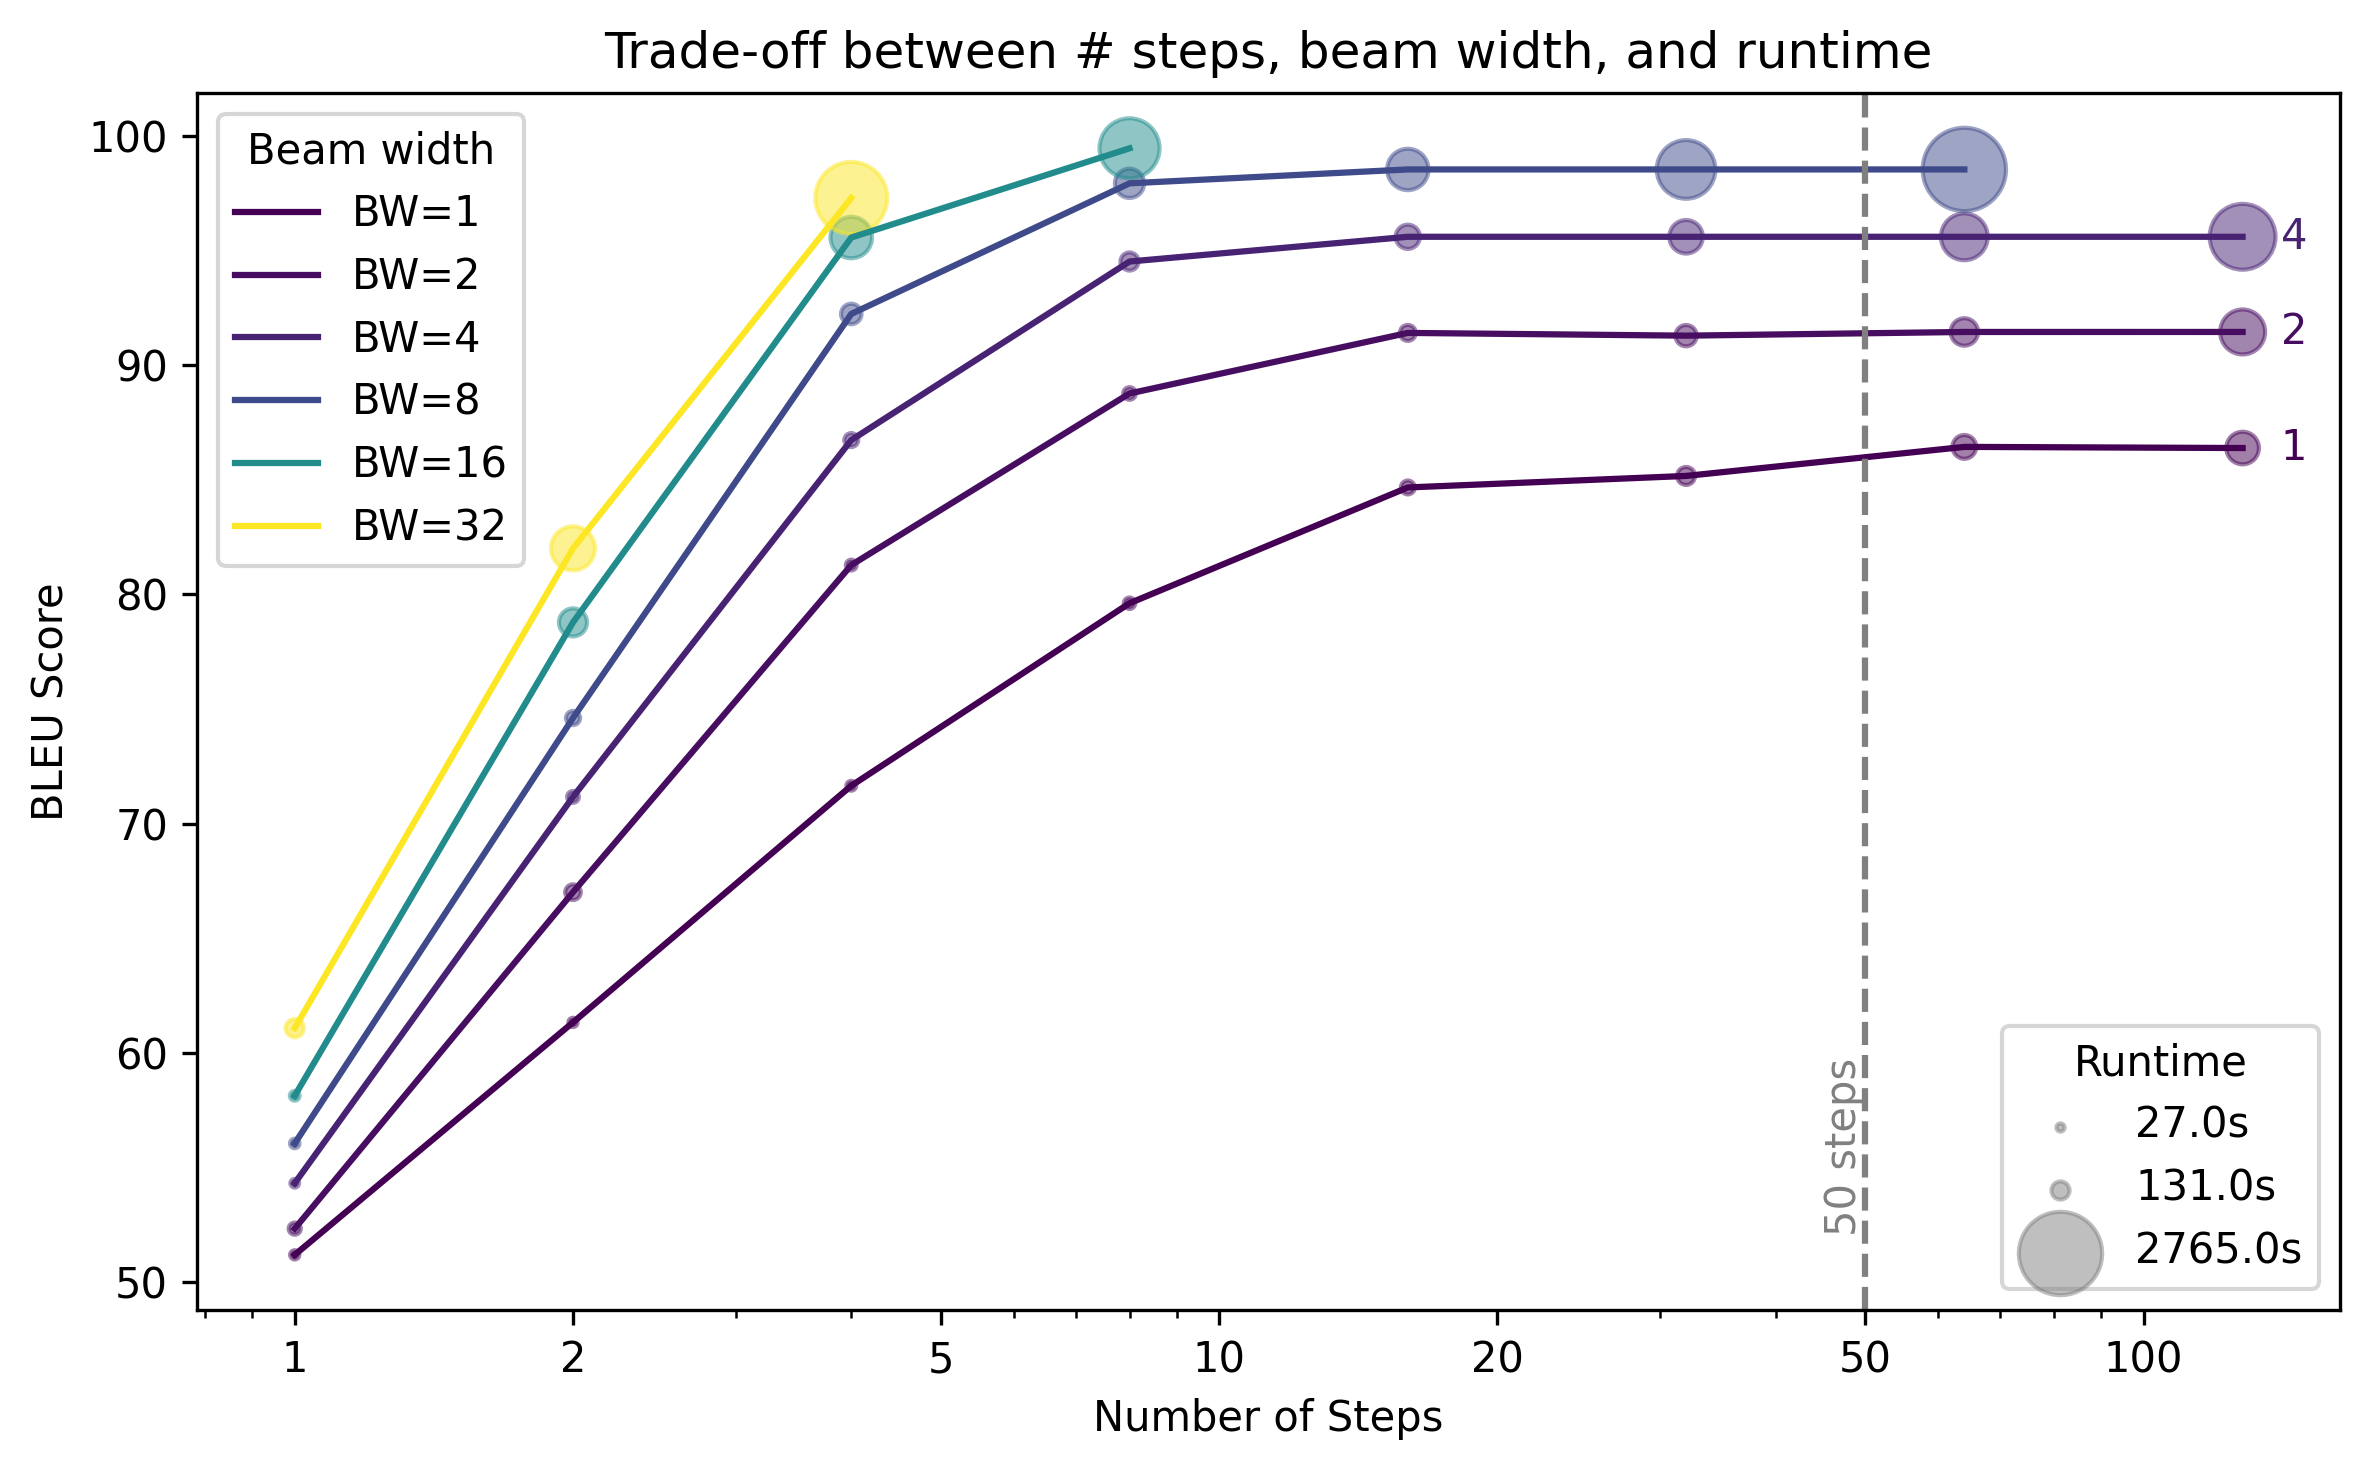

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("./data/num_steps_vs_beam_width.csv")
data = data[["num_steps", "sequence_beam_width", "bleu_score", "Runtime"]]

data.dropna(inplace=True)

data["num_steps"] = data["num_steps"].astype(int)
data["sequence_beam_width"] = data["sequence_beam_width"].astype(int)
data["Runtime"] = data["Runtime"].astype(float)

pivot_bleu = data.pivot_table(
    index="num_steps", columns="sequence_beam_width", values="bleu_score", aggfunc="mean"
)

pivot_runtime = data.pivot_table(
    index="num_steps", columns="sequence_beam_width", values="Runtime", aggfunc="mean"
)

pivot_bleu = pivot_bleu.sort_index().sort_index(axis=1)
pivot_runtime = pivot_runtime.reindex_like(pivot_bleu)

scale_factor = 100 / data["Runtime"].max()

#plt.style.use("seaborn-whitegrid")

bw_list = sorted(pivot_bleu.columns)
norm    = mpl.colors.Normalize(vmin=bw_list[0], vmax=bw_list[-1])
cmap    = plt.get_cmap("viridis")

plt.figure(figsize=(8,5), dpi=300)
for bw in bw_list:
    color = cmap(norm(bw))
    sizes = pivot_runtime[bw] * scale_factor * 4
    plt.plot(pivot_bleu.index, pivot_bleu[bw],
             color=color, label=f"BW={bw}")
    plt.scatter(pivot_bleu.index, pivot_bleu[bw],
                s=sizes, alpha=0.5, color=color)
    # direct label at end
    plt.text(pivot_bleu.index.max()*1.1,
             pivot_bleu[bw].iloc[-1],
             str(bw), va="center", color=color)

# 50 steps annotation
plt.axvline(50, color="gray", ls="--")
plt.text(50, 52, "50 steps", rotation=90,
         va="bottom", ha="right", color="gray")

# ticks & labels
plt.xscale("log")
plt.xticks([1,2,5,10,20,50,100], ["1","2","5","10","20","50","100"])
plt.xlabel("Number of Steps")
plt.ylabel("BLEU Score")
plt.title("Trade-off between # steps, beam width, and runtime")

# separate legends
l1 = plt.legend(title="Beam width", loc="upper left")
size_vals = [data["Runtime"].min(),
             data["Runtime"].median(),
             data["Runtime"].max()]
handles = [ plt.scatter([],[], s=rt*scale_factor*4, color="gray", alpha=0.5)
            for rt in size_vals ]
labels  = [f"{rt:.1f}s" for rt in size_vals]
l2 = plt.legend(handles, labels, title="Runtime", loc="lower right")
plt.gca().add_artist(l1)

plt.tight_layout()
plt.savefig("num_steps_vs_beam_width_runtime.pdf")
plt.show()



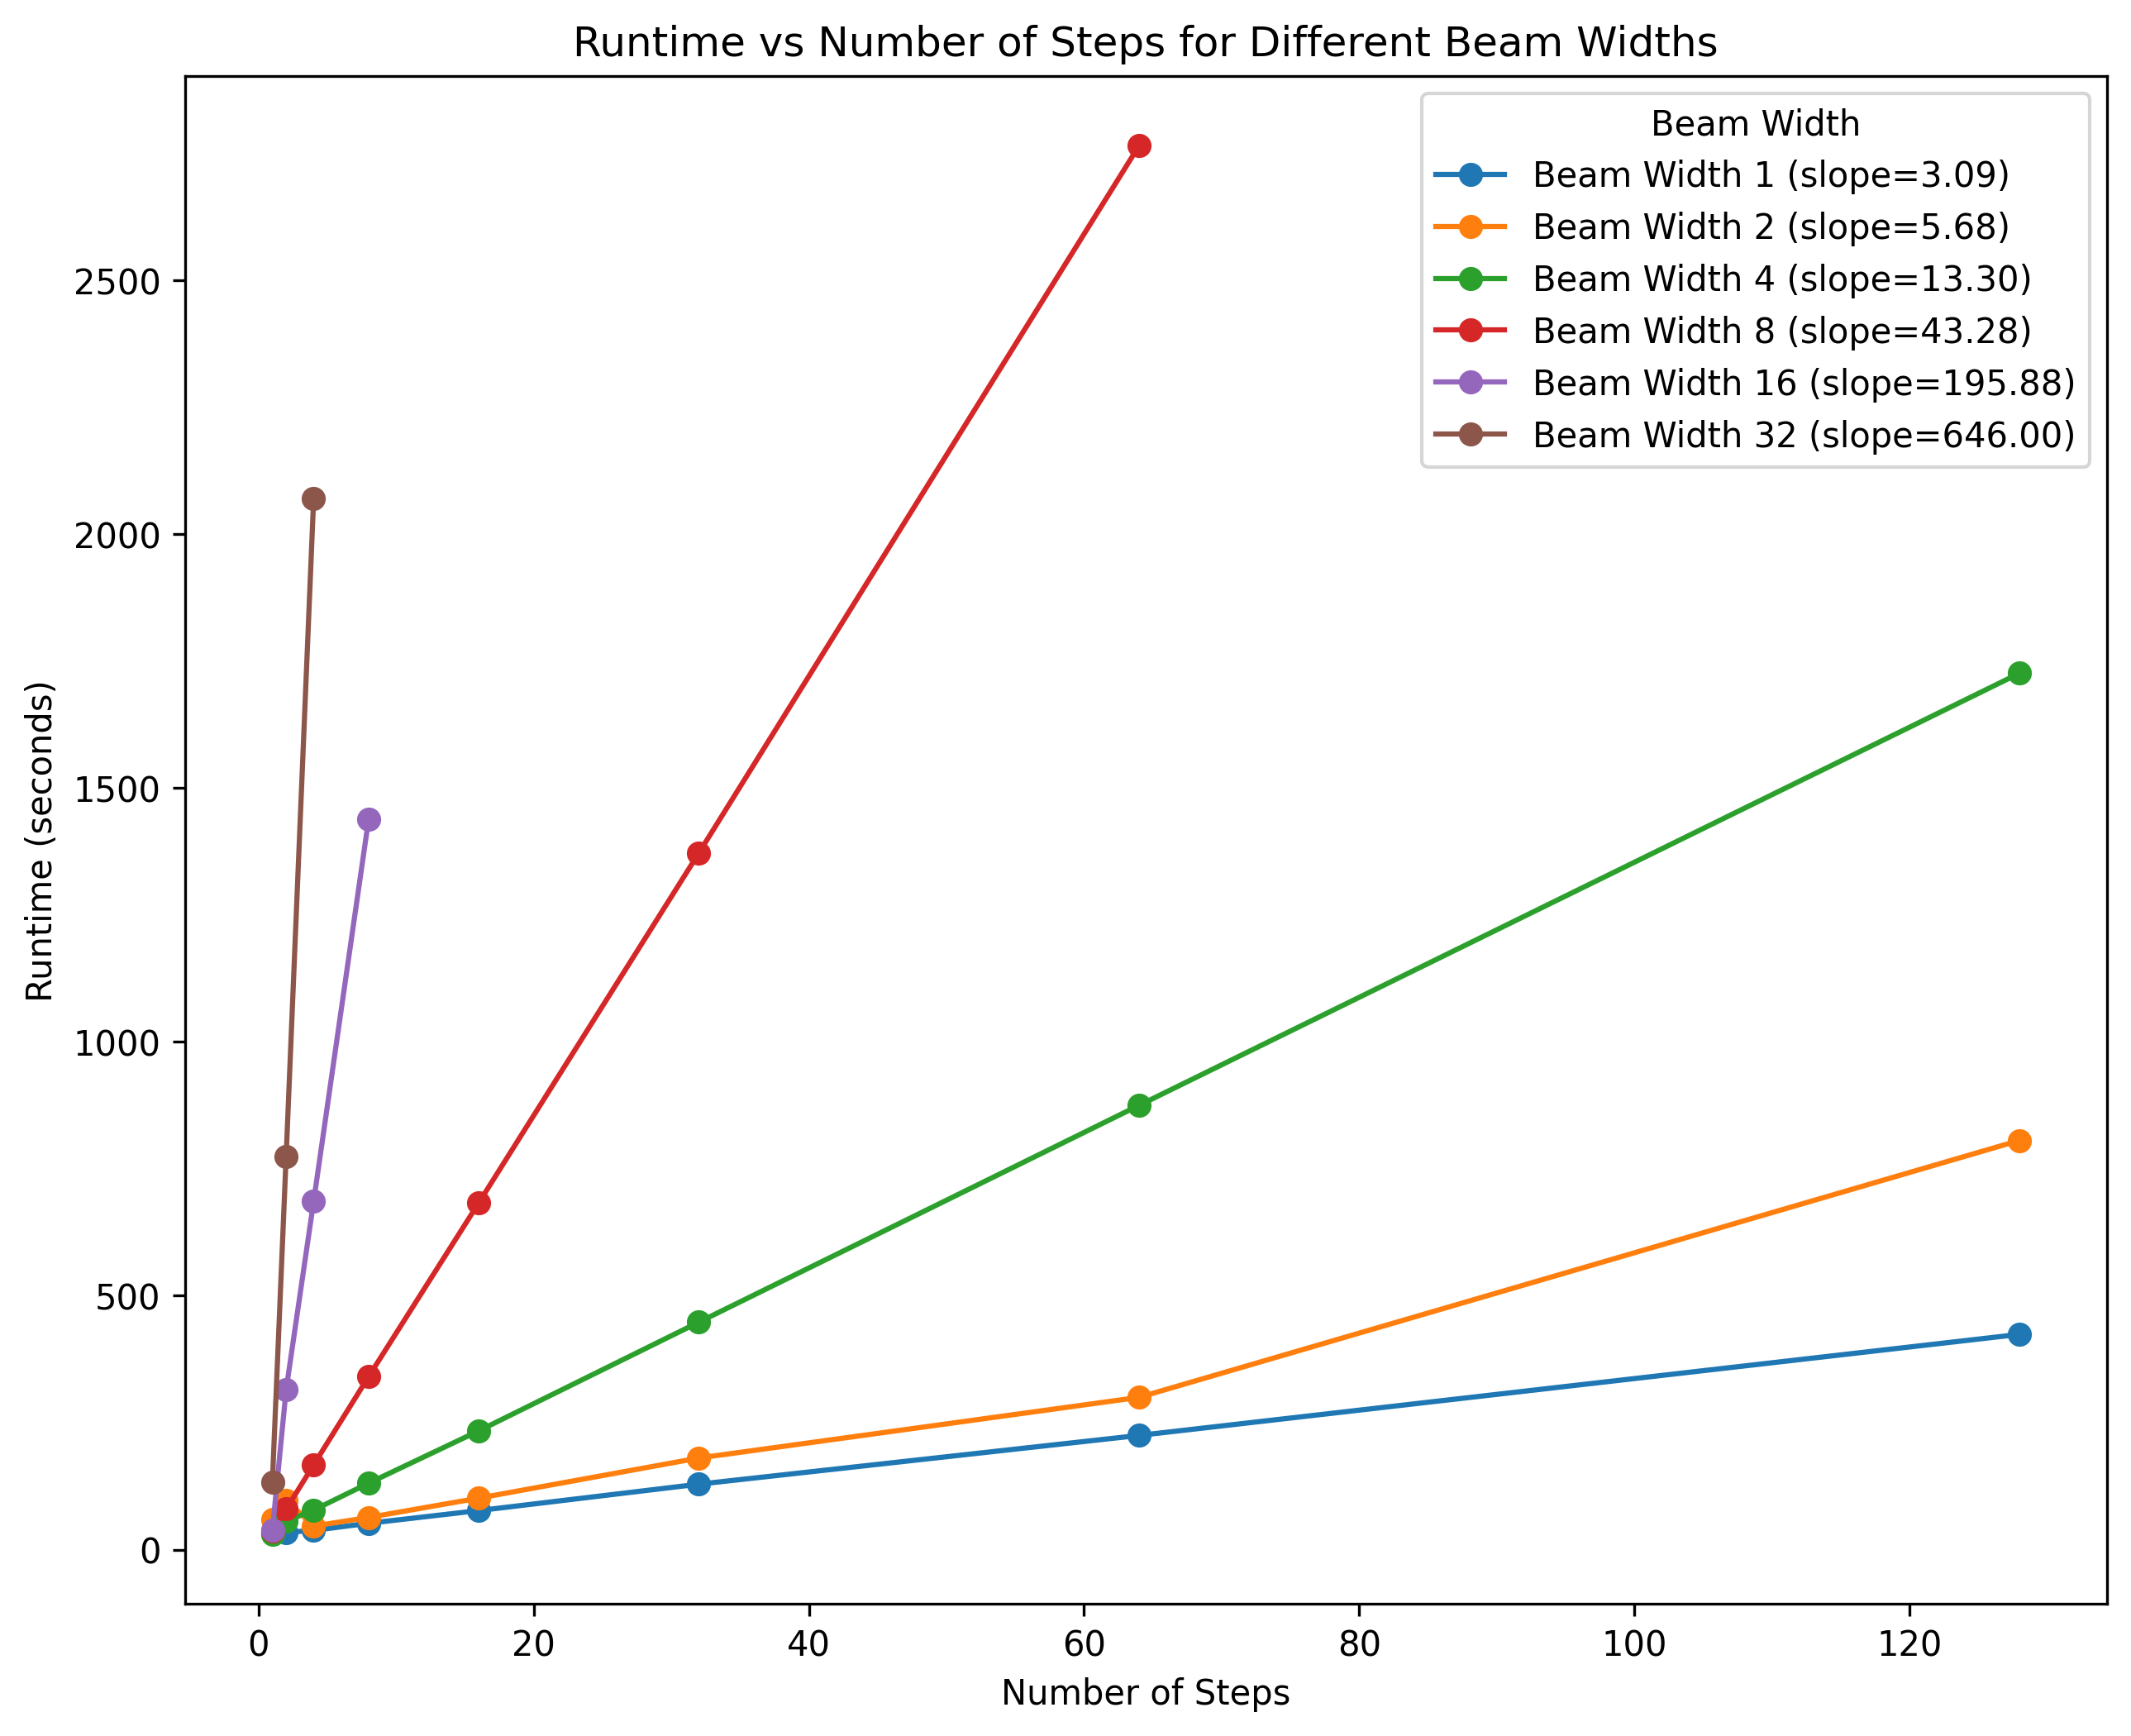

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

data = pd.read_csv("./data/num_steps_vs_beam_width.csv")
data = data[["num_steps", "sequence_beam_width", "bleu_score", "Runtime"]]

data.dropna(inplace=True)

data["num_steps"] = data["num_steps"].astype(int)
data["sequence_beam_width"] = data["sequence_beam_width"].astype(int)
data["Runtime"] = data["Runtime"].astype(float)

pivot_runtime = data.pivot_table(
    index="num_steps", columns="sequence_beam_width", values="Runtime", aggfunc="mean"
)

pivot_runtime = pivot_runtime.sort_index().sort_index(axis=1)

plt.figure(figsize=(10, 8), dpi=300)

for beam_width in pivot_runtime.columns:
    x = pivot_runtime.index
    y = pivot_runtime[beam_width]


    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]


    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)


    plt.plot(x, y, marker="o", label=f"Beam Width {beam_width} (slope={slope:.2f})")

plt.xlabel("Number of Steps")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs Number of Steps for Different Beam Widths")

plt.legend(title="Beam Width")

plt.savefig("num_steps_vs_beam_width_runtime_with_slope.pdf")

plt.show()

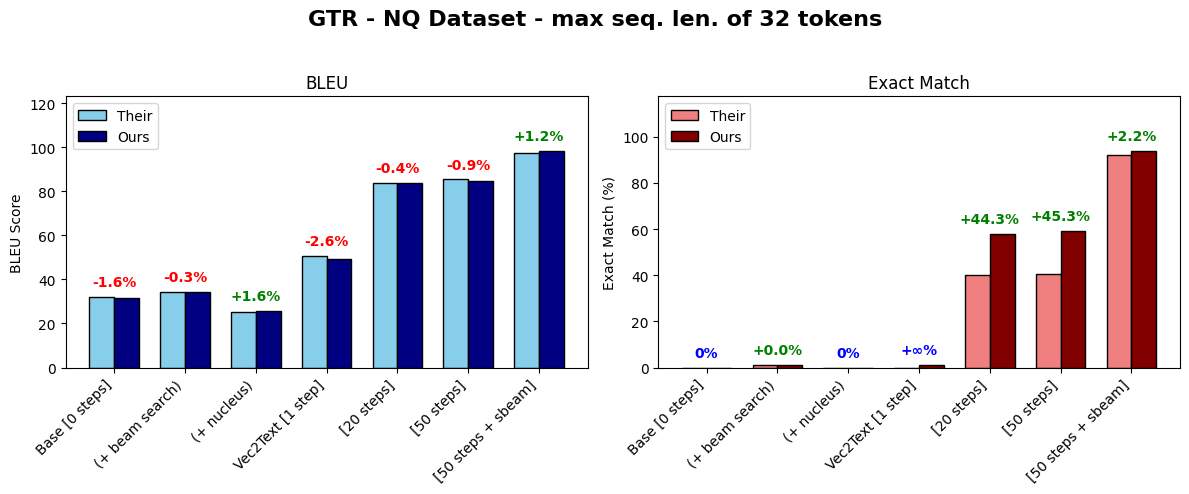

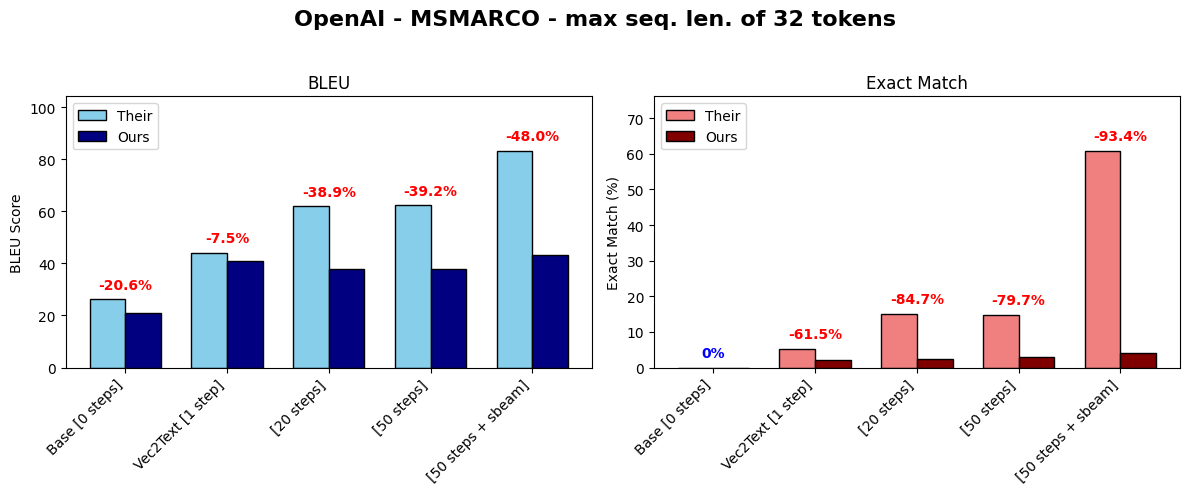

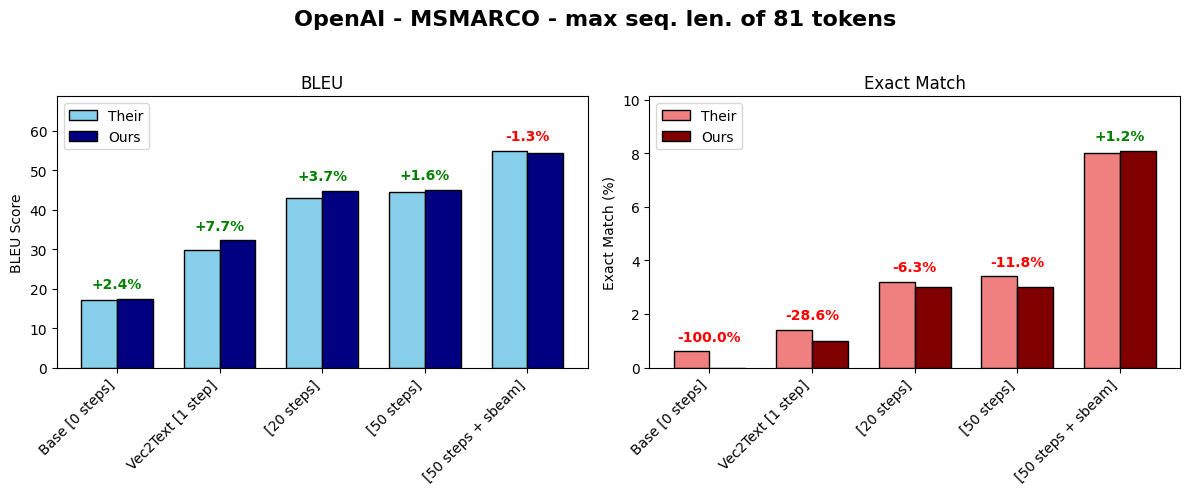

In [5]:
import matplotlib.pyplot as plt
import numpy as np

methods_nq = [
    "Base [0 steps]",
    "(+ beam search)",
    "(+ nucleus)",
    "Vec2Text [1 step]",
    "[20 steps]",
    "[50 steps]",
    "[50 steps + sbeam]",
]

bleu_their_nq = [31.9, 34.5, 25.3, 50.7, 83.9, 85.4, 97.3]
bleu_ours_nq = [31.4, 34.4, 25.7, 49.4, 83.6, 84.6, 98.5]

exact_their_nq = [0, 1, 0, 0, 40.2, 40.6, 92]
exact_ours_nq = [0, 1, 0, 1, 58, 59, 94]

methods_msmarco1 = [
    "Base [0 steps]",
    "Vec2Text [1 step]",
    "[20 steps]",
    "[50 steps]",
    "[50 steps + sbeam]",
]

bleu_their_msmarco1 = [26.2, 44.1, 61.9, 62.3, 83.4]
bleu_ours_msmarco1 = [20.8, 40.8, 37.79, 37.9, 43.4]

exact_their_msmarco1 = [0, 5.2, 15, 14.8, 60.9]
exact_ours_msmarco1 = [0, 2, 2.3, 3, 4]

methods_msmarco2 = [
    "Base [0 steps]",
    "Vec2Text [1 step]",
    "[20 steps]",
    "[50 steps]",
    "[50 steps + sbeam]",
]

bleu_their_msmarco2 = [17, 29.9, 43.1, 44.4, 55]
bleu_ours_msmarco2 = [17.4, 32.2, 44.7, 45.1, 54.3]

exact_their_msmarco2 = [0.6, 1.4, 3.2, 3.4, 8]
exact_ours_msmarco2 = [0, 1, 3, 3, 8.1]


def percentage_diff(their_val, our_val):
    if their_val == 0:
        if our_val == 0:
            return "0%"
        else:
            return "+∞%"
    diff_pct = ((our_val - their_val) / their_val) * 100
    return f"{diff_pct:+.1f}%"


def plot_dataset(dataset_name, methods, bleu_their, bleu_ours, exact_their, exact_ours):
    fig, (ax_bleu, ax_exact) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(dataset_name, fontsize=16, fontweight="bold")

    x = np.arange(len(methods))
    width = 0.35

    ax_bleu.bar(
        x - width / 2, bleu_their, width, label="Their", color="skyblue", edgecolor="black"
    )
    ax_bleu.bar(x + width / 2, bleu_ours, width, label="Ours", color="navy", edgecolor="black")
    ax_bleu.set_title("BLEU")
    ax_bleu.set_xticks(x)
    ax_bleu.set_xticklabels(methods, rotation=45, ha="right")
    ax_bleu.set_ylabel("BLEU Score")

    max_bleu = max(bleu_their + bleu_ours)
    ax_bleu.set_ylim(top=max_bleu * 1.25)

    for i in range(len(methods)):
        diff_str = percentage_diff(bleu_their[i], bleu_ours[i])
        y_pos = max(bleu_their[i], bleu_ours[i]) + (max_bleu * 0.05)
        color = (
            "green"
            if ("+" in diff_str and "∞" not in diff_str)
            else ("red" if "-" in diff_str else "blue")
        )
        ax_bleu.annotate(diff_str, (x[i], y_pos), ha="center", color=color, fontweight="bold")

    ax_bleu.legend()

    ax_exact.bar(
        x - width / 2, exact_their, width, label="Their", color="lightcoral", edgecolor="black"
    )
    ax_exact.bar(x + width / 2, exact_ours, width, label="Ours", color="maroon", edgecolor="black")
    ax_exact.set_title("Exact Match")
    ax_exact.set_xticks(x)
    ax_exact.set_xticklabels(methods, rotation=45, ha="right")
    ax_exact.set_ylabel("Exact Match (%)")

    max_exact = max(exact_their + exact_ours)
    ax_exact.set_ylim(top=max_exact * 1.25)

    for i in range(len(methods)):
        diff_str = percentage_diff(exact_their[i], exact_ours[i])
        y_pos = max(exact_their[i], exact_ours[i]) + (max_exact * 0.05)
        color = (
            "green"
            if ("+" in diff_str and "∞" not in diff_str)
            else ("red" if "-" in diff_str else "blue")
        )
        ax_exact.annotate(diff_str, (x[i], y_pos), ha="center", color=color, fontweight="bold")

    ax_exact.legend()

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_dataset(
    "GTR - NQ Dataset - max seq. len. of 32 tokens",
    methods_nq,
    bleu_their_nq,
    bleu_ours_nq,
    exact_their_nq,
    exact_ours_nq,
)
plot_dataset(
    "OpenAI - MSMARCO - max seq. len. of 32 tokens",
    methods_msmarco1,
    bleu_their_msmarco1,
    bleu_ours_msmarco1,
    exact_their_msmarco1,
    exact_ours_msmarco1,
)
plot_dataset(
    "OpenAI - MSMARCO - max seq. len. of 81 tokens",
    methods_msmarco2,
    bleu_their_msmarco2,
    bleu_ours_msmarco2,
    exact_their_msmarco2,
    exact_ours_msmarco2,
)

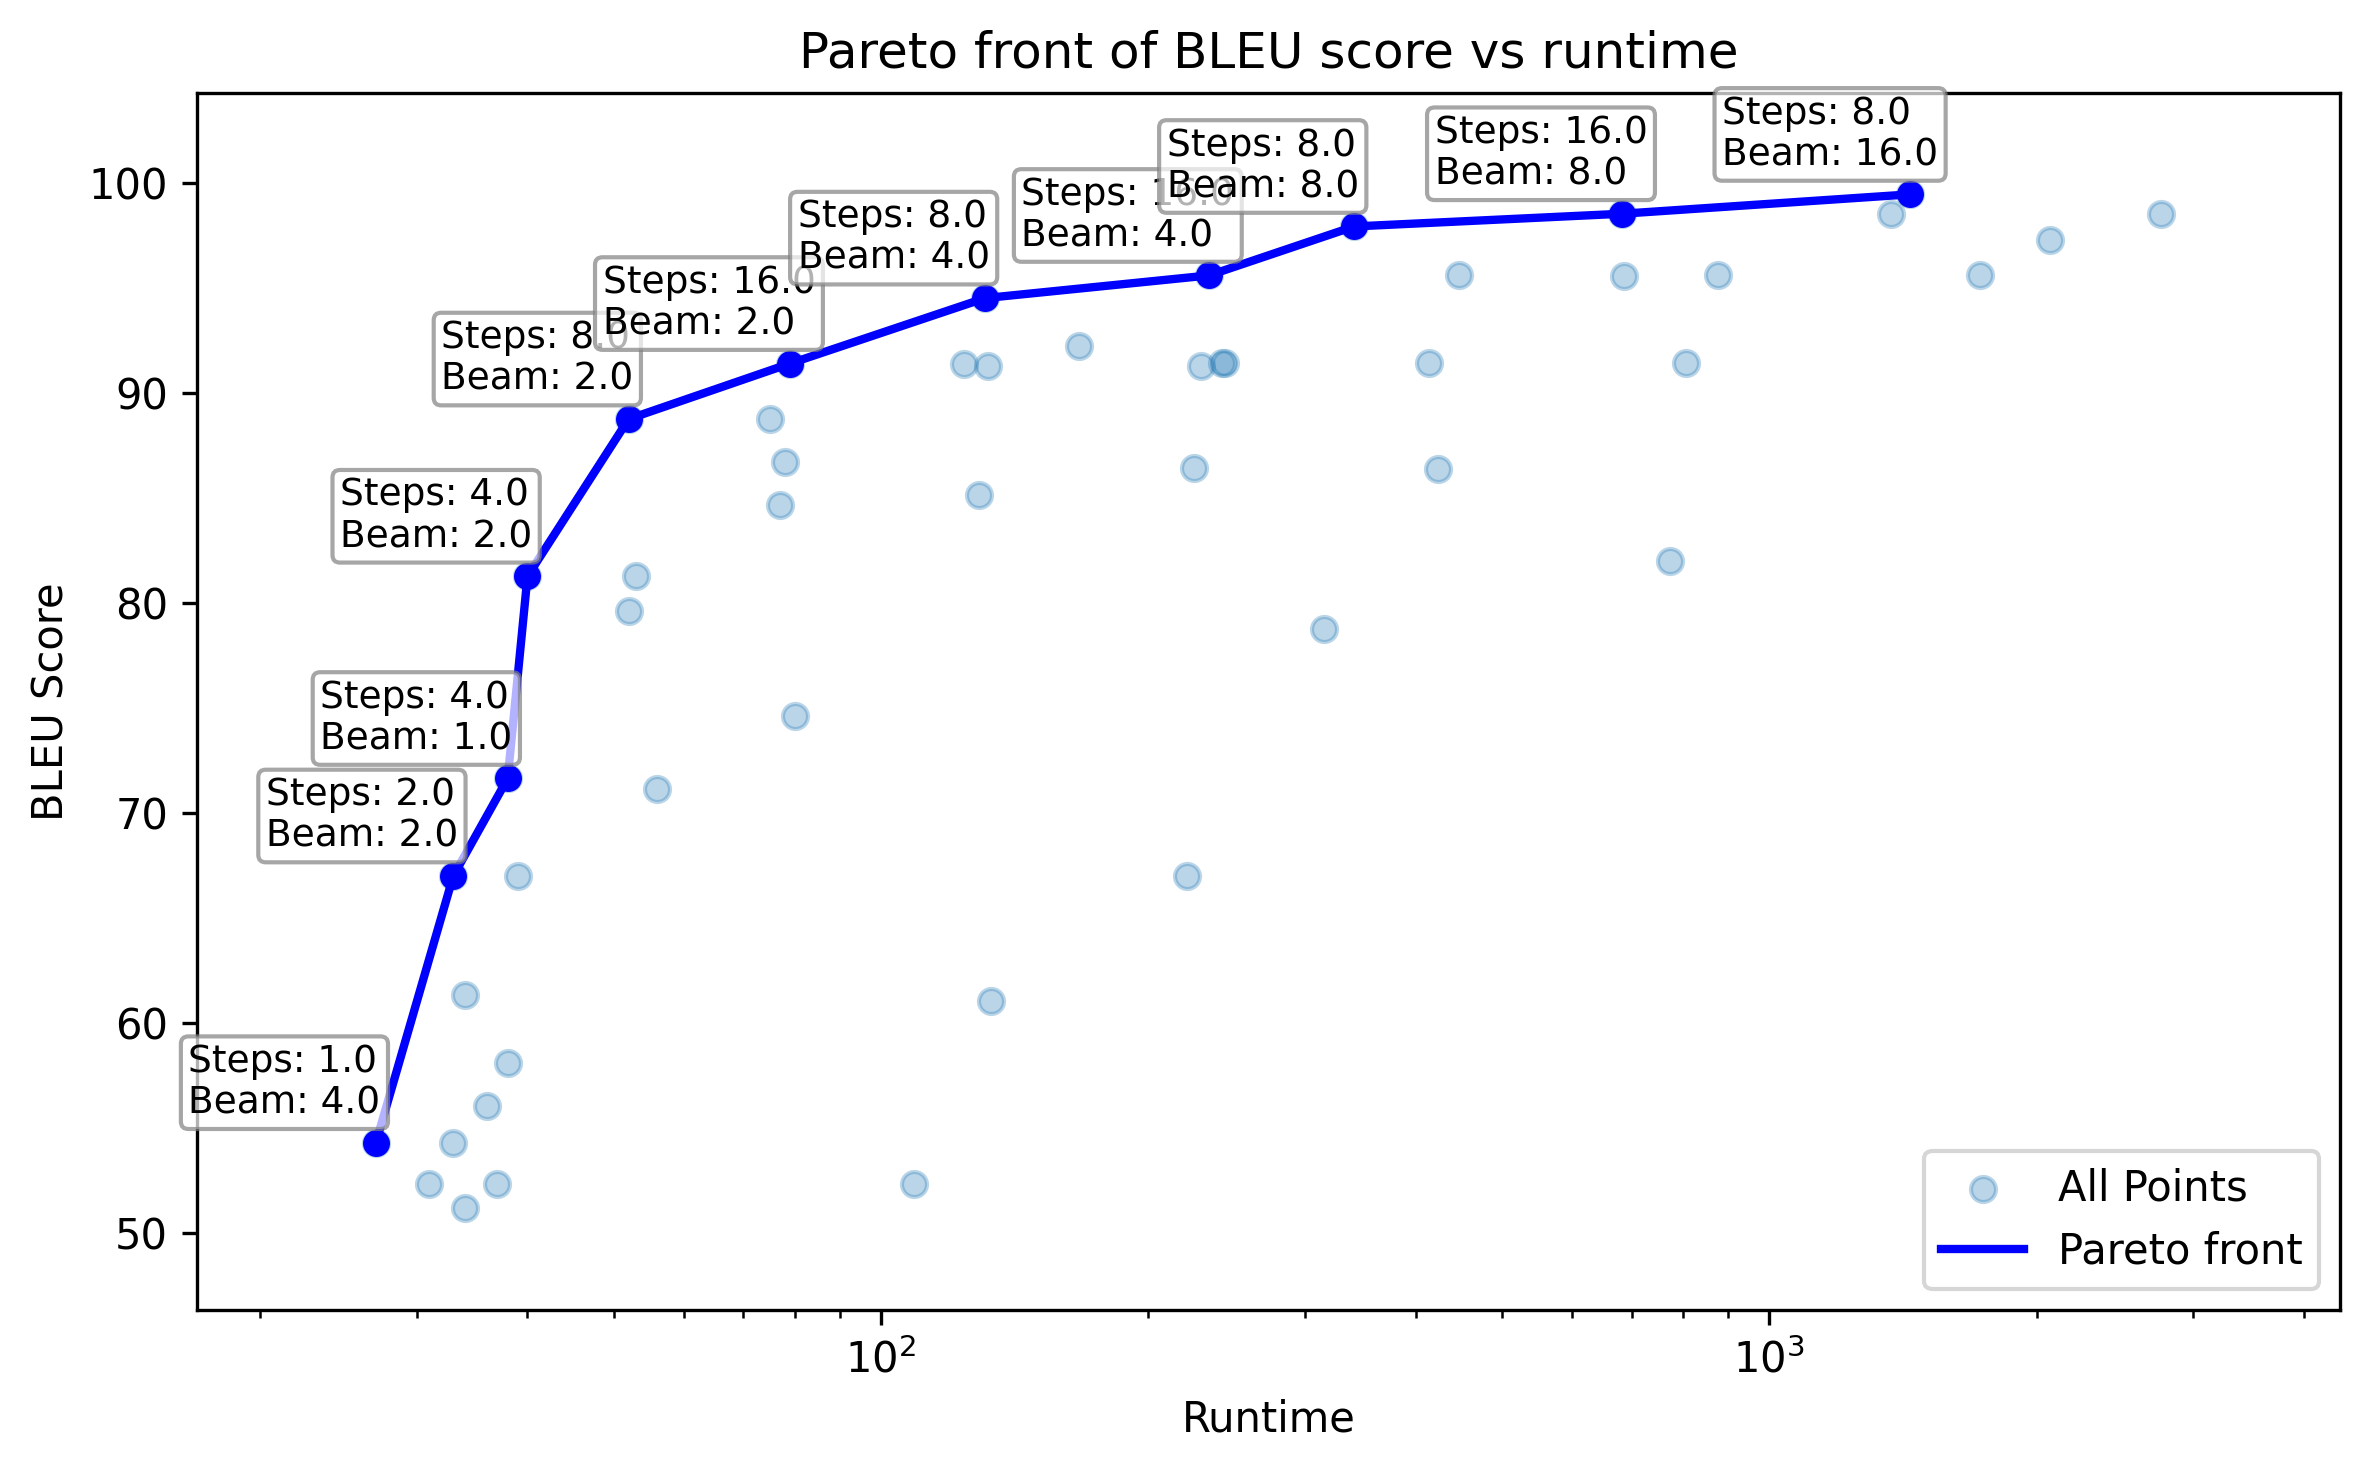

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("./data/num_steps_vs_beam_width.csv")
data = data[["num_steps", "sequence_beam_width", "bleu_score", "Runtime"]]

data.dropna(inplace=True)

data["num_steps"] = data["num_steps"].astype(int)
data["sequence_beam_width"] = data["sequence_beam_width"].astype(int)
data["Runtime"] = data["Runtime"].astype(float)

data_sorted = data.sort_values(["Runtime", "bleu_score"], ascending=[True, False])

pareto_front = []
last_bleu = -1
for _, row in data_sorted.iterrows():
    if row["bleu_score"] > last_bleu:
        pareto_front.append(row)
        last_bleu = row["bleu_score"]

pareto_front = pd.DataFrame(pareto_front)

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

ax.scatter(data["Runtime"], data["bleu_score"], alpha=0.3, label="All Points")

ax.plot(
    pareto_front["Runtime"], pareto_front["bleu_score"], "b-", linewidth=2, label="Pareto front"
)
ax.scatter(pareto_front["Runtime"], pareto_front["bleu_score"], color="b", s=30)

for idx, row in pareto_front.iterrows():
    ax.annotate(
        f"Steps: {row['num_steps']}\nBeam: {row['sequence_beam_width']}",
        (row["Runtime"], row["bleu_score"]),
        textcoords="offset points",
        xytext=(-45, 7),
        ha="left",
        fontsize=9,               # make it a bit smaller if needed
        bbox=dict(boxstyle="round,pad=0.2", edgecolor="gray", facecolor="white", alpha=0.7),
        clip_on=False,            # let it draw outside the axes
    )

ax.set_xscale("log")
ax.set_xmargin(0.1)
ax.set_ymargin(0.1)

ax.set_xlabel("Runtime")
ax.set_ylabel("BLEU Score")
ax.set_title("Pareto front of BLEU score vs runtime")
ax.legend(loc="lower right")

plt.tight_layout()   # <-- adjust margins
plt.savefig("pareto_front_bleu_vs_runtime.pdf", bbox_inches="tight")
plt.show()


In [7]:
import pandas as pd

data = pd.read_csv("data/num_steps_vs_beam_width.csv")

data = data[
    [
        "num_steps",
        "sequence_beam_width",
        "batch_size",
        "max_seq_length",
        "bleu_score",
        "exact_match",
        "Runtime",
    ]
]

data.rename(
    columns={
        "num_steps": "Steps",
        "sequence_beam_width": "Beam Width",
        "batch_size": "Batch Size",
        "max_seq_length": "Max Seq Length",
        "bleu_score": "BLEU",
        "exact_match": "Exact Match",
        "Runtime": "Runtime (s)",
    },
    inplace=True,
)

data["BLEU"] = data["BLEU"].round(2)
data["Exact Match"] = data["Exact Match"].round(2)
data["Runtime (s)"] = data["Runtime (s)"].round(2)

data = data[
    [
        "Steps",
        "Beam Width",
        "Batch Size",
        "Max Seq Length",
        "BLEU",
        "Exact Match",
        "Runtime (s)",
    ]
]


data.sort_values(by=["Steps", "Beam Width"], inplace=True)

latex_table = data.to_latex(
    index=False,
    column_format="ccccccc",


    caption="Inversion Parameters Trade-off Results",
    label="tab:trade_off_table",
    escape=False,
)

with open("results_table.tex", "w") as file:
    file.write(latex_table)